In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error

In [118]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
RMV = ['rainfall','id']
FEATURES = [c for c in train.columns if not c in RMV]
print("Our features are:")
print( FEATURES )

Our features are:
['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']


In [119]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost
print("Using XGBoost version",xgboost.__version__)

Using XGBoost version 3.0.0


In [169]:
%%time
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"rainfall"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"rainfall"]
    x_test = test[FEATURES].copy()

    params = {
        'max_depth': 3, 'learning_rate': 0.030429463807184344, 'subsample': 0.9891803640695981, 'colsample_bytree': 0.987274150659399, 'alpha': 6.551274888446281, 'lambda': 7.391871113821021
    }
    model = XGBClassifier(**params)
    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=100
    )

    # INFER OOF
    oof_xgb[test_index] = model.predict_proba(x_valid)[:,1]
    # INFER TEST
    pred_xgb += model.predict_proba(x_test)[:,1]

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-logloss:0.57702
[99]	validation_0-logloss:0.38412
#########################
### Fold 2
#########################
[0]	validation_0-logloss:0.51523
[99]	validation_0-logloss:0.33330
#########################
### Fold 3
#########################
[0]	validation_0-logloss:0.55199
[99]	validation_0-logloss:0.33437
#########################
### Fold 4
#########################
[0]	validation_0-logloss:0.51161
[99]	validation_0-logloss:0.28646
#########################
### Fold 5
#########################
[0]	validation_0-logloss:0.58986
[99]	validation_0-logloss:0.38053
CPU times: total: 13.6 s
Wall time: 1.01 s


In [170]:
from sklearn.metrics import roc_auc_score
true = train.rainfall.values
m = roc_auc_score(true, oof_xgb)
print(f"XGBoost CV Score AUC = {m:.3f}")

XGBoost CV Score AUC = 0.888


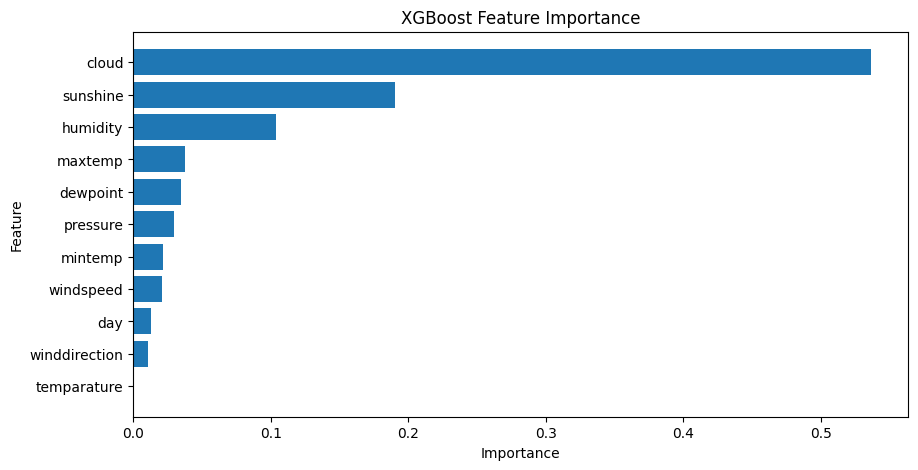

In [171]:
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [172]:
submission = pd.DataFrame({
    "id": test['id'],  # 测试集的唯一标识列
    "rainfall": pred_xgb# 预测结果
})
submission.to_csv("submission.csv", index=False)